# Predict survivors of the titanic with sklearn Random Forest


### We need a few imports

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn_evaluation import plot

### Load the data in a pandas dataframe

In [84]:
file = "data/titanic_train.csv"
df = pd.read_csv(file)

# get shape of df : (entries, columns)
df.shape

(891, 12)

In [85]:

# Get a summary of the dataset: num of columns, entries
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### There are 891 total entries, and 12 columns (features) per entry

### Let's have a look at a few data entries:

In [86]:
df.head(n=5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### The following variables are likely irrelevant to the analysis:
```
PassengerId : passenger unique integer identifier
Name : the passenger name  
Ticket: the ticket number  
Cabin: the cabin number 
```
### So let's drop them from the dataframe:

In [87]:
df = df.drop(['PassengerId','Name','Ticket','Cabin'], 1)
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### This is how the remaining variables look like:

In [88]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### Let's look at them more closely:


#### *Survived* is the variable we need to predict, how does it look like?

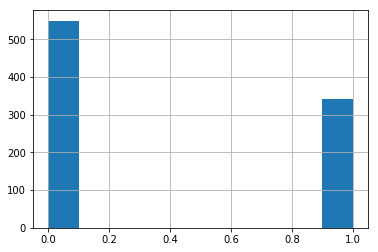

In [89]:
df.Survived.hist()

### *Survived* is a binary variable with values 0 (not survived) or 1 (survived)
#### We can use any binary classification model to predict *Survived*, here we are going to use Random Forest from sklearn

### We notice that *Sex* and *Embarked* are string categorical variables: 

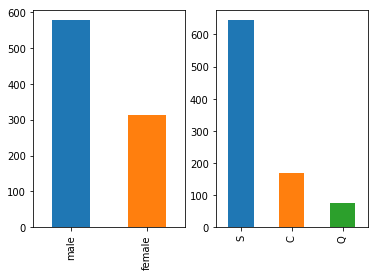

In [90]:
sSex = df['Sex'].value_counts()
sEmbk = df['Embarked'].value_counts()

fig, axes = plt.subplots(nrows=1, ncols=2)
sSex.plot(kind='bar', ax=axes[0])
sEmbk.plot(kind='bar',ax=axes[1])

#### Sklearn models need numerical variables, so let's create dummy variables.
#### Sex has only two values, let's create a map:

In [91]:
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

#### *Embarked*, the port where a passenger embarked  (C = Cherbourg; Q = Queenstown; S = Southampton) has 3 values, let's create dummies, but drop one class because is redundant

In [92]:
Embark_location = pd.get_dummies(df['Embarked'], drop_first=True)

# Drop original variable, and add the new one to the dataframe
df.drop(['Embarked'], axis=1, inplace=True)
df = pd.concat([df, Embark_location], axis=1)

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Q,S
0,0,3,0,22.0,1,0,7.2500,0,1
1,1,1,1,38.0,1,0,71.2833,0,0
2,1,3,1,26.0,0,0,7.9250,0,1
3,1,1,1,35.0,1,0,53.1000,0,1
4,0,3,0,35.0,0,0,8.0500,0,1


### Before going ahead, let's check if we have NULL/NAN values

In [93]:
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Q             0
S             0
dtype: int64

### *Age* has 177 NULL values
Let's replace *Age* NULL values with the median of *Age*, calculated in different groups for *Pclass* and *Sex*

In [94]:
df.Age = df.groupby(['Sex','Pclass'])['Age'].apply(lambda x: x.fillna(x.mean()))
df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Q           0
S           0
dtype: int64

No more NaN values.. we are ready to build our model!

### Let's create the targets array and the features array to train

In [95]:
# Array of targets:
Y = df['Survived'] 

# Array of features:
df = df.drop('Survived', 1)
X = df.as_matrix()

#### First, let's split our sample in two: a training sample and a test sample

In [96]:
 X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1, test_size=0.2)

We will train our model using the X_train, y_train subsample, and test it on the X_test, y_test sample (20% of the total data).

This is to define an unbiased model accuracy, as the value we get from the training sample is always going to be higher than on an indipendent sample

In [97]:
# Create Classifier 
clf =  RandomForestClassifier()

# Train Classifier on training set
clf.fit(X_train,  y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Let's estimate the accuracy of the model

In [101]:
# Accuracy score on Training set:
y_pred = clf.predict(X_train) 
score = metrics.accuracy_score(y_train, y_pred)
print("Score on Training set: %.3f" % score)

# Accuracy score on Test set:
y_pred = clf.predict(X_test)
score = metrics.accuracy_score(y_test, y_pred)
print("Score on Test set: %.3f" % score)

Score on Training set: 0.966
Score on Test set: 0.793


As mentioned before, the training set always has higher accuracy, because it can be overfitted. The score for the Test set is more accurate.

Finally, the confusion matrix provides more detailed information on our predictions:

Correct Negative: 96 False Positive: 10   
Correct Positive: 46 False Negative: 27  
print(metrics.classification_report(y_test, y_pred))

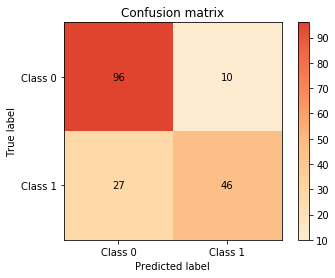

In [99]:
conmat = metrics.confusion_matrix(y_test, y_pred)
plot.confusion_matrix(y_test, y_pred)
plt.show()
print(metrics.classification_report(y_test, y_pred))